In [1]:
import pandas as pd
import os
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
from sklearn.model_selection import GridSearchCV
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch

In [2]:
# Load IMDb data
def load_imdb_data(directory):
    data = {'text': [], 'label': []}
    for sentiment in ['pos', 'neg']:
        for filename in os.listdir(os.path.join(directory, sentiment)):
            if filename.endswith('.txt'):
                with open(os.path.join(directory, sentiment, filename), 'r', encoding='utf-8') as file:
                    text = file.read()
                    label = 1 if sentiment == 'pos' else 0
                    data['text'].append(text)
                    data['label'].append(label)

    return pd.DataFrame(data)

In [3]:
imdb_path = 'D:\Abhishek\Job Prep\Sentiment Analysis Product Reviews\Imdb Movie'

In [4]:
# Load IMDb training data
imdb_train_data = load_imdb_data(os.path.join(imdb_path, 'train'))

In [5]:
# Load IMDb testing data
imdb_test_data = load_imdb_data(os.path.join(imdb_path, 'test'))

In [6]:
imdb_train_data.head()

,text,label
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


In [7]:
imdb_test_data.head()

,text,label
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1


In [8]:
# Load the Twitter training dataset
twitter_train_data = pd.read_csv('Twitter/twitter_train.csv', encoding='latin1')

# Assuming 'Sentiment' is the sentiment column in the dataset
X = twitter_train_data['SentimentText']
y = twitter_train_data['Sentiment']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create new training and testing DataFrames
new_train_data = pd.DataFrame({'SentimentText': X_train, 'Sentiment': y_train})
new_test_data = pd.DataFrame({'SentimentText': X_test, 'Sentiment': y_test})

# Save the new training and testing datasets to CSV files
new_train_data.to_csv('Twitter/new_train.csv', index=False)
new_test_data.to_csv('Twitter/new_test.csv', index=False)




In [9]:
new_train_data.head()

,SentimentText,Sentiment
58519,"@bellazombie if you can't sleep, I suggest wat...",1
38238,@ameeraaa__ ii was also at school. =] haha was...,1
3806,=- La La la. I love country music.,1
27925,@Abeeliever gmornin my little madeleine cake! ...,1
6006,#cheapspeakers have everybody at rancho dancin...,0


In [10]:
new_test_data.head()

,SentimentText,Sentiment
33965,@Allieandra wheeee!,1
22853,@a02toyota Thank you for the FF! Good to meet ya,1
19448,@ electricbath Eewwww. Gross! So sorry hayward...,0
9732,"#followfriday - I'm a little late, but here's ...",1
7129,"#icanhelp in shopping (deals), personal assist...",1


In [11]:
# Function for text preprocessing
def preprocess_text(text):
    # Remove HTML tags using BeautifulSoup
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove special characters and numbers, keep only alphabets
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    text = ' '.join([word for word in tokens if word not in stop_words])
    
    return text

# Apply text preprocessing to IMDb training data
imdb_train_data['preprocessed_text'] = imdb_train_data['text'].apply(preprocess_text)

# Apply text preprocessing to IMDb test data
imdb_test_data['preprocessed_text'] = imdb_test_data['text'].apply(preprocess_text)

# Apply text preprocessing to Twitter training data
new_train_data['preprocessed_text'] = new_train_data['SentimentText'].apply(preprocess_text)

# Apply text preprocessing to Twitter test data
new_test_data['preprocessed_text'] = new_test_data['SentimentText'].apply(preprocess_text)


[nltk_data] Error loading stopwords: <urlopen error [WinError 10054]
[nltk_data]     An existing connection was forcibly closed by the
[nltk_data]     remote host>
[nltk_data] Error loading punkt: <urlopen error [WinError 10054] An
[nltk_data]     existing connection was forcibly closed by the remote
[nltk_data]     host>
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23908\3509232758.py:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23908\3509232758.py:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23908\3509232758.py:10: MarkupResemblesLocatorWarning: The input looks more

IMDb Training Data Summary:
             label
count  25000.00000
mean       0.50000
std        0.50001
min        0.00000
25%        0.00000
50%        0.50000
75%        1.00000
max        1.00000


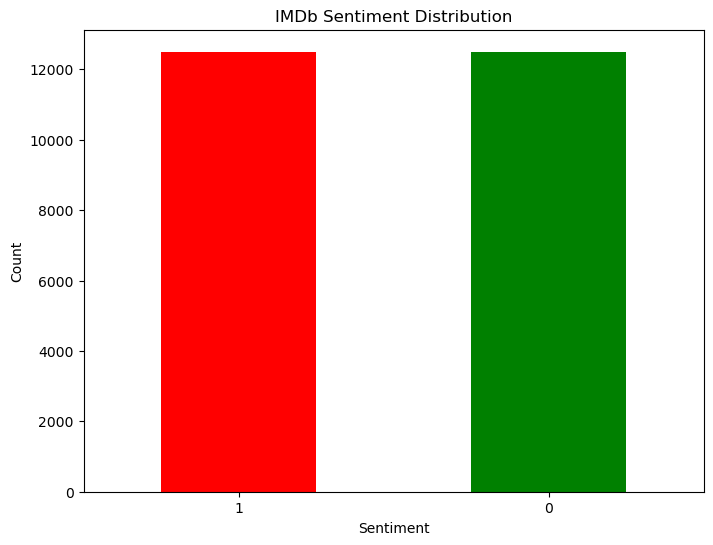

In [12]:
# Basic Statistics
print("IMDb Training Data Summary:")
print(imdb_train_data.describe())

# Distribution of Sentiments
plt.figure(figsize=(8, 6))
imdb_train_data['label'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('IMDb Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

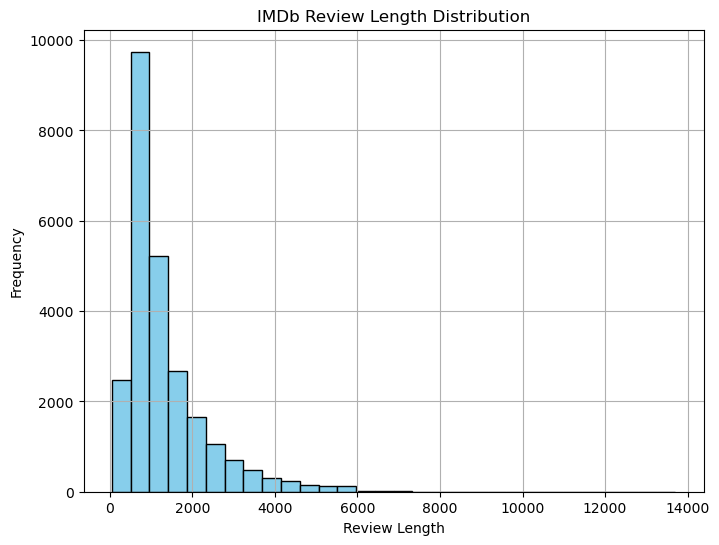

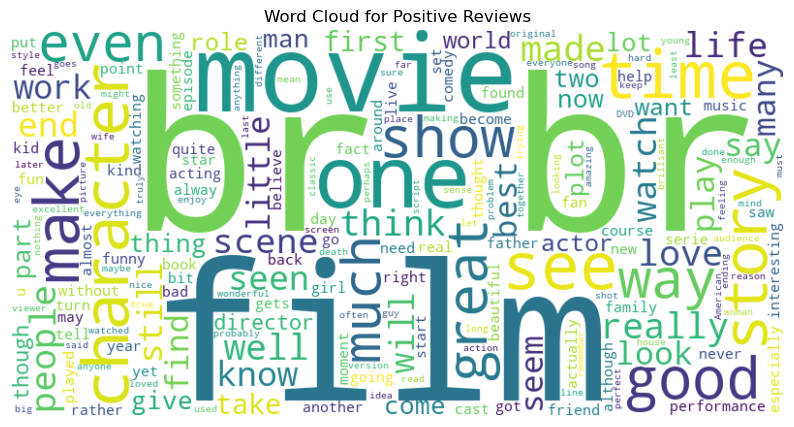

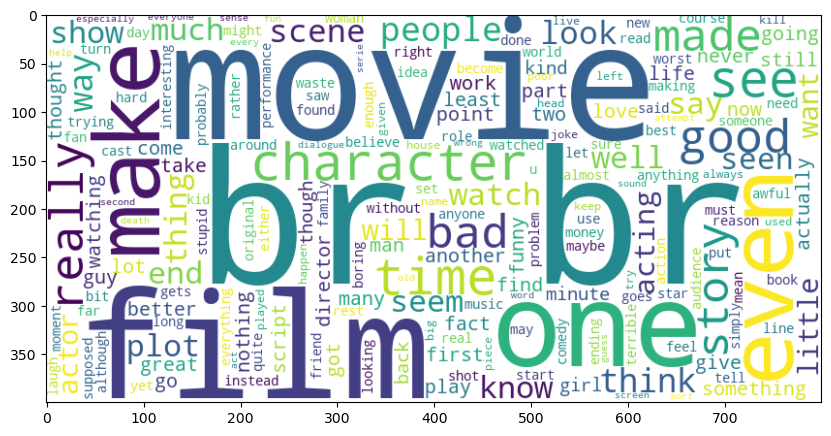

In [13]:
# Additional IMDb EDA
imdb_train_data['text_length'] = imdb_train_data['text'].apply(len)

# Distribution of Review Lengths
plt.figure(figsize=(8, 6))
imdb_train_data['text_length'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('IMDb Review Length Distribution')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

# Word Cloud for Positive Reviews
from wordcloud import WordCloud

positive_reviews = ' '.join(imdb_train_data[imdb_train_data['label'] == 1]['text'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

# Word Cloud for Negative Reviews
negative_reviews = ' '.join(imdb_train_data[imdb_train_data['label'] == 0]['text'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')



Twitter Training Data Summary:
          Sentiment
count  79991.000000
mean       0.565176
std        0.495737
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000


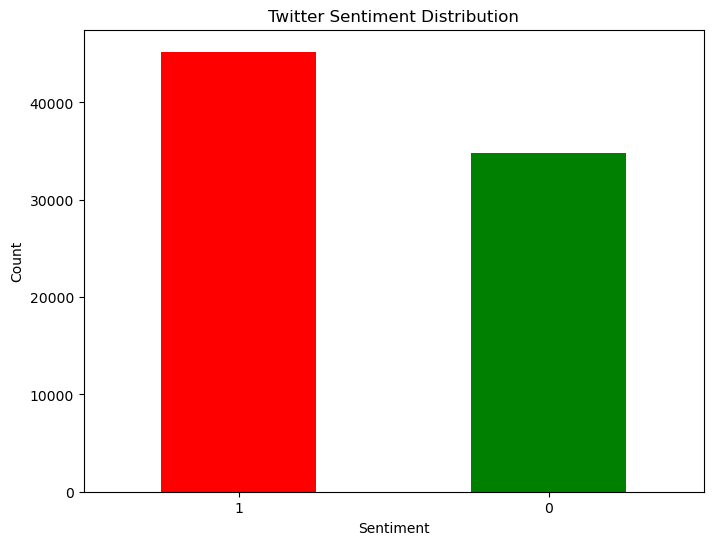

In [14]:
# Basic Statistics
print("\nTwitter Training Data Summary:")
print(new_train_data.describe())

# Distribution of Sentiments
plt.figure(figsize=(8, 6))
new_train_data['Sentiment'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Twitter Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


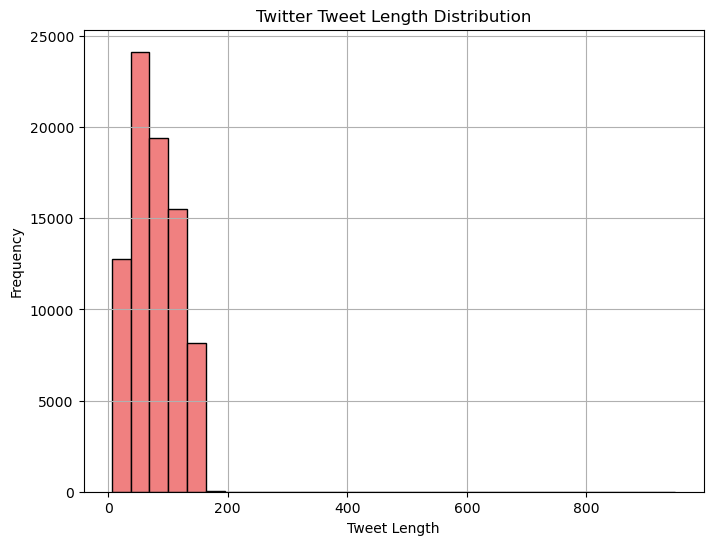

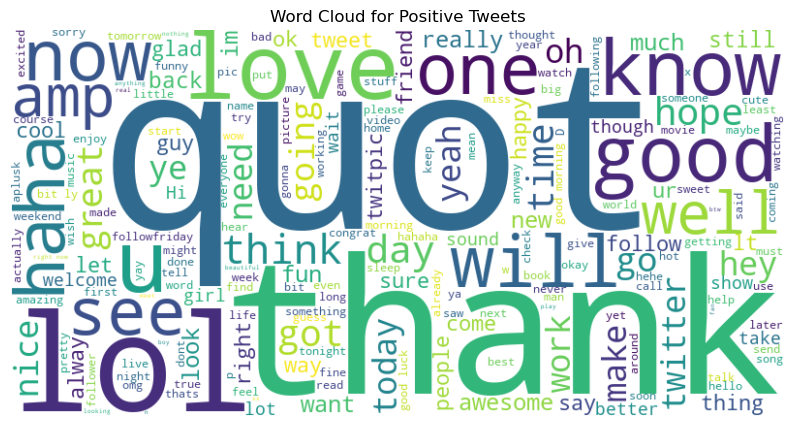

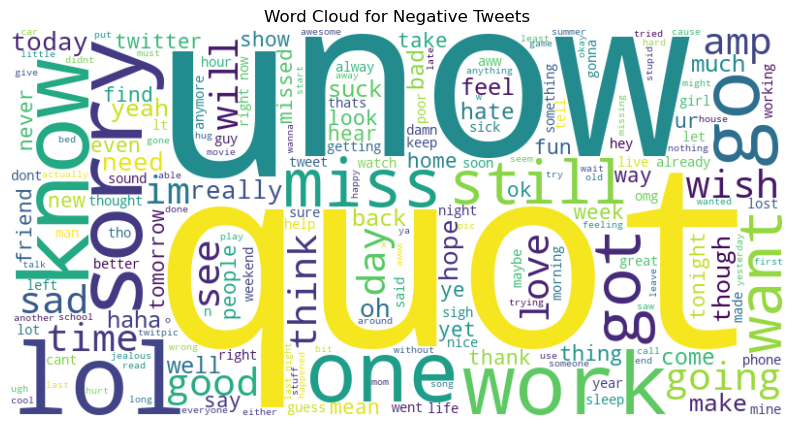

In [15]:
# Additional Twitter EDA
new_train_data['text_length'] = new_train_data['SentimentText'].apply(len)
from wordcloud import WordCloud

# Distribution of Tweet Lengths
plt.figure(figsize=(8, 6))
new_train_data['text_length'].hist(bins=30, color='lightcoral', edgecolor='black')
plt.title('Twitter Tweet Length Distribution')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

# Word Cloud for Positive Tweets
positive_tweets = ' '.join(new_train_data[new_train_data['Sentiment'] == 1]['SentimentText'])
wordcloud_positive_twitter = WordCloud(width=800, height=400, background_color='white').generate(positive_tweets)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_positive_twitter, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Tweets')
plt.show()

# Word Cloud for Negative Tweets
negative_tweets = ' '.join(new_train_data[new_train_data['Sentiment'] == 0]['SentimentText'])
wordcloud_negative_twitter = WordCloud(width=800, height=400, background_color='white').generate(negative_tweets)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negative_twitter, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Tweets')
plt.show()



In [16]:
# Specify the maximum number of features
max_features = 1000  # Adjust this number based on your available memory

# Define the CountVectorizer with n-grams and limited features
ngram_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=max_features)

# Transform the IMDb training and testing data
ngram_features_imdb_train = ngram_vectorizer.fit_transform(imdb_train_data['preprocessed_text'])
ngram_features_imdb_test = ngram_vectorizer.transform(imdb_test_data['preprocessed_text'])


In [17]:
# Specify the maximum number of features
max_features_twitter = 1000  # Adjust this number based on your available memory

# Define the CountVectorizer with n-grams and limited features for Twitter
ngram_vectorizer_twitter = CountVectorizer(ngram_range=(1, 2), max_features=max_features_twitter)

# Transform the Twitter training and testing data
ngram_features_twitter_train = ngram_vectorizer_twitter.fit_transform(new_train_data['preprocessed_text'])
ngram_features_twitter_test = ngram_vectorizer_twitter.transform(new_test_data['preprocessed_text'])


In [37]:
# Create Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(ngram_features_imdb_train, imdb_train_data['label'])
nb_predictions_imdb = nb_model.predict(ngram_features_imdb_test)

# Evaluate Naive Bayes on IMDb dataset
print("Naive Bayes - IMDb:")
print("Accuracy:", accuracy_score(imdb_test_data['label'], nb_predictions_imdb))
print("Classification Report:")
print(classification_report(imdb_test_data['label'], nb_predictions_imdb))


Naive Bayes - IMDb:
Accuracy: 0.83012
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     12500
           1       0.83      0.83      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



In [38]:
# Create SVM model
svm_model = SVC()
svm_model.fit(ngram_features_imdb_train, imdb_train_data['label'])
svm_predictions_imdb = svm_model.predict(ngram_features_imdb_test)

# Evaluate SVM on IMDb dataset
print("\nSVM - IMDb:")
print("Accuracy:", accuracy_score(imdb_test_data['label'], svm_predictions_imdb))
print("Classification Report:")
print(classification_report(imdb_test_data['label'], svm_predictions_imdb))



SVM - IMDb:
Accuracy: 0.85464
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85     12500
           1       0.84      0.87      0.86     12500

    accuracy                           0.85     25000
   macro avg       0.86      0.85      0.85     25000
weighted avg       0.86      0.85      0.85     25000



In [39]:

# Create Neural Network model
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
nn_model.fit(ngram_features_imdb_train, imdb_train_data['label'])
nn_predictions_imdb = nn_model.predict(ngram_features_imdb_test)

# Evaluate Neural Network on IMDb dataset
print("\nNeural Network - IMDb:")
print("Accuracy:", accuracy_score(imdb_test_data['label'], nn_predictions_imdb))
print("Classification Report:")
print(classification_report(imdb_test_data['label'], nn_predictions_imdb))


Neural Network - IMDb:
Accuracy: 0.84524
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     12500
           1       0.84      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



In [40]:
nb_model_twitter = MultinomialNB()
nb_model_twitter.fit(ngram_features_twitter_train, new_train_data['Sentiment'])
nb_predictions_twitter = nb_model_twitter.predict(ngram_features_twitter_test)

# Evaluate Naive Bayes on Twitter dataset
print("\nNaive Bayes - Twitter:")
print("Accuracy:", accuracy_score(new_test_data['Sentiment'], nb_predictions_twitter))
print("Classification Report:")
print(classification_report(new_test_data['Sentiment'], nb_predictions_twitter))



Naive Bayes - Twitter:
Accuracy: 0.7287728772877288
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.64      0.67      8750
           1       0.74      0.80      0.77     11248

    accuracy                           0.73     19998
   macro avg       0.73      0.72      0.72     19998
weighted avg       0.73      0.73      0.73     19998



In [41]:
# Create SVM model for Twitter
svm_model_twitter = SVC()
svm_model_twitter.fit(ngram_features_twitter_train, new_train_data['Sentiment']) 
svm_predictions_twitter = svm_model_twitter.predict(ngram_features_twitter_test)

# Evaluate SVM on Twitter dataset
print("\nSVM - Twitter:")
print("Accuracy:", accuracy_score(new_test_data['Sentiment'], svm_predictions_twitter))
print("Classification Report:")
print(classification_report(new_test_data['Sentiment'], svm_predictions_twitter))


SVM - Twitter:
Accuracy: 0.7334233423342335
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.59      0.66      8750
           1       0.73      0.84      0.78     11248

    accuracy                           0.73     19998
   macro avg       0.74      0.72      0.72     19998
weighted avg       0.74      0.73      0.73     19998



In [42]:
# Create Neural Network model for Twitter
nn_model_twitter = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
nn_model_twitter.fit(ngram_features_twitter_train, new_train_data['Sentiment'])
nn_predictions_twitter = nn_model_twitter.predict(ngram_features_twitter_test)

# Evaluate Neural Network on Twitter dataset
print("\nNeural Network - Twitter:")
print("Accuracy:", accuracy_score(new_test_data['Sentiment'], nn_predictions_twitter))
print("Classification Report:")
print(classification_report(new_test_data['Sentiment'], nn_predictions_twitter))



Neural Network - Twitter:
Accuracy: 0.6886188618861886
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.60      0.63      8750
           1       0.71      0.75      0.73     11248

    accuracy                           0.69     19998
   macro avg       0.68      0.68      0.68     19998
weighted avg       0.69      0.69      0.69     19998



In [45]:
# Save the current models
joblib.dump(nb_predictions_imdb, 'naive_bayes_imdb_model.joblib')
joblib.dump(svm_predictions_imdb, 'svm_imdb_model.joblib')
joblib.dump(nn_predictions_imdb, 'neural_network_imdb_model.joblib')

joblib.dump(nb_predictions_twitter, 'naive_bayes_twitter_model.joblib')
joblib.dump(svm_predictions_twitter, 'svm_twitter_model.joblib')
joblib.dump(nn_predictions_twitter, 'neural_network_twitter_model.joblib')


['neural_network_twitter_model.joblib']

In [46]:
# Define the parameter grid for Naive Bayes
nb_param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

# Perform grid search for Naive Bayes on IMDb dataset
nb_grid_search = GridSearchCV(MultinomialNB(), nb_param_grid, cv=3, scoring='accuracy')
nb_grid_search.fit(ngram_features_imdb_train, imdb_train_data['label'])

# Get the best parameters for Naive Bayes
best_nb_params = nb_grid_search.best_params_
print("Best Naive Bayes Parameters:", best_nb_params)

# Train Naive Bayes with the best parameters
best_nb_model = MultinomialNB(alpha=best_nb_params['alpha'])
best_nb_model.fit(ngram_features_imdb_train, imdb_train_data['label'])

# Evaluate Naive Bayes on IMDb dataset
nb_predictions_imdb = best_nb_model.predict(ngram_features_imdb_test)
print("\nNaive Bayes - IMDb:")
print("Accuracy:", accuracy_score(imdb_test_data['label'], nb_predictions_imdb))
print("Classification Report:")
print(classification_report(imdb_test_data['label'], nb_predictions_imdb))



Best Naive Bayes Parameters: {'alpha': 0.1}

Naive Bayes - IMDb:
Accuracy: 0.8302
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     12500
           1       0.83      0.83      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



In [47]:

# Repeat the process for SVM and Neural Network
# Define the parameter grid for SVM
svm_param_grid = {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf', 'poly']}

# Perform grid search for SVM on IMDb dataset
svm_grid_search = GridSearchCV(SVC(), svm_param_grid, cv=3, scoring='accuracy')
svm_grid_search.fit(ngram_features_imdb_train, imdb_train_data['label'])

# Get the best parameters for SVM
best_svm_params = svm_grid_search.best_params_
print("\nBest SVM Parameters:", best_svm_params)

# Train SVM with the best parameters
best_svm_model = SVC(C=best_svm_params['C'], kernel=best_svm_params['kernel'])
best_svm_model.fit(ngram_features_imdb_train, imdb_train_data['label'])

# Evaluate SVM on IMDb dataset
svm_predictions_imdb = best_svm_model.predict(ngram_features_imdb_test)
print("\nSVM - IMDb:")
print("Accuracy:", accuracy_score(imdb_test_data['label'], svm_predictions_imdb))
print("Classification Report:")
print(classification_report(imdb_test_data['label'], svm_predictions_imdb))


Best SVM Parameters: {'C': 1.0, 'kernel': 'rbf'}

SVM - IMDb:
Accuracy: 0.85464
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85     12500
           1       0.84      0.87      0.86     12500

    accuracy                           0.85     25000
   macro avg       0.86      0.85      0.85     25000
weighted avg       0.86      0.85      0.85     25000



In [48]:
# Define the parameter grid for Neural Network
nn_param_grid = {'hidden_layer_sizes': [(50,), (100,), (150,)], 'max_iter': [200, 300, 400]}

# Perform grid search for Neural Network on IMDb dataset
nn_grid_search = GridSearchCV(MLPClassifier(), nn_param_grid, cv=3, scoring='accuracy')
nn_grid_search.fit(ngram_features_imdb_train, imdb_train_data['label'])

# Get the best parameters for Neural Network
best_nn_params = nn_grid_search.best_params_
print("\nBest Neural Network Parameters:", best_nn_params)

# Train Neural Network with the best parameters
best_nn_model = MLPClassifier(hidden_layer_sizes=best_nn_params['hidden_layer_sizes'], max_iter=best_nn_params['max_iter'])
best_nn_model.fit(ngram_features_imdb_train, imdb_train_data['label'])

# Evaluate Neural Network on IMDb dataset
nn_predictions_imdb = best_nn_model.predict(ngram_features_imdb_test)
print("\nNeural Network - IMDb:")
print("Accuracy:", accuracy_score(imdb_test_data['label'], nn_predictions_imdb))
print("Classification Report:")
print(classification_report(imdb_test_data['label'], nn_predictions_imdb))


Best Neural Network Parameters: {'hidden_layer_sizes': (150,), 'max_iter': 200}

Neural Network - IMDb:
Accuracy: 0.8472
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85     12500
           1       0.84      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



In [49]:
# Define the parameter grid for Naive Bayes on Twitter
nb_param_grid_twitter = {'alpha': [0.1, 0.5, 1.0, 2.0]}

# Perform grid search for Naive Bayes on Twitter dataset
nb_grid_search_twitter = GridSearchCV(MultinomialNB(), nb_param_grid_twitter, cv=3, scoring='accuracy')
nb_grid_search_twitter.fit(ngram_features_twitter_train, new_train_data['Sentiment'])

# Get the best parameters for Naive Bayes on Twitter
best_nb_params_twitter = nb_grid_search_twitter.best_params_
print("Best Naive Bayes Parameters - Twitter:", best_nb_params_twitter)

# Train Naive Bayes with the best parameters on Twitter
best_nb_model_twitter = MultinomialNB(alpha=best_nb_params_twitter['alpha'])
best_nb_model_twitter.fit(ngram_features_twitter_train, new_train_data['Sentiment'])

# Evaluate Naive Bayes on Twitter dataset
nb_predictions_twitter = best_nb_model_twitter.predict(ngram_features_twitter_test)
print("\nNaive Bayes - Twitter:")
print("Accuracy:", accuracy_score(new_test_data['Sentiment'], nb_predictions_twitter))
print("Classification Report:")
print(classification_report(new_test_data['Sentiment'], nb_predictions_twitter))


Best Naive Bayes Parameters - Twitter: {'alpha': 2.0}

Naive Bayes - Twitter:
Accuracy: 0.7289228922892289
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.64      0.67      8750
           1       0.74      0.80      0.77     11248

    accuracy                           0.73     19998
   macro avg       0.73      0.72      0.72     19998
weighted avg       0.73      0.73      0.73     19998



In [50]:

# Repeat the process for SVM and Neural Network on Twitter
# Define the parameter grid for SVM on Twitter
svm_param_grid_twitter = {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf', 'poly']}

# Perform grid search for SVM on Twitter dataset
svm_grid_search_twitter = GridSearchCV(SVC(), svm_param_grid_twitter, cv=3, scoring='accuracy')
svm_grid_search_twitter.fit(ngram_features_twitter_train, new_train_data['Sentiment'])

# Get the best parameters for SVM on Twitter
best_svm_params_twitter = svm_grid_search_twitter.best_params_
print("\nBest SVM Parameters - Twitter:", best_svm_params_twitter)

# Train SVM with the best parameters on Twitter
best_svm_model_twitter = SVC(C=best_svm_params_twitter['C'], kernel=best_svm_params_twitter['kernel'])
best_svm_model_twitter.fit(ngram_features_twitter_train, new_train_data['Sentiment'])

# Evaluate SVM on Twitter dataset
svm_predictions_twitter = best_svm_model_twitter.predict(ngram_features_twitter_test)
print("\nSVM - Twitter:")
print("Accuracy:", accuracy_score(new_test_data['Sentiment'], svm_predictions_twitter))
print("Classification Report:")
print(classification_report(new_test_data['Sentiment'], svm_predictions_twitter))



Best SVM Parameters - Twitter: {'C': 1.0, 'kernel': 'rbf'}

SVM - Twitter:
Accuracy: 0.7334233423342335
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.59      0.66      8750
           1       0.73      0.84      0.78     11248

    accuracy                           0.73     19998
   macro avg       0.74      0.72      0.72     19998
weighted avg       0.74      0.73      0.73     19998



In [51]:
# Define the parameter grid for Neural Network on Twitter
nn_param_grid_twitter = {'hidden_layer_sizes': [(50,), (100,), (150,)], 'max_iter': [200, 300, 400]}

# Perform grid search for Neural Network on Twitter dataset
nn_grid_search_twitter = GridSearchCV(MLPClassifier(), nn_param_grid_twitter, cv=3, scoring='accuracy')
nn_grid_search_twitter.fit(ngram_features_twitter_train, new_train_data['Sentiment'])

# Get the best parameters for Neural Network on Twitter
best_nn_params_twitter = nn_grid_search_twitter.best_params_
print("\nBest Neural Network Parameters - Twitter:", best_nn_params_twitter)

# Train Neural Network with the best parameters on Twitter
best_nn_model_twitter = MLPClassifier(hidden_layer_sizes=best_nn_params_twitter['hidden_layer_sizes'],
                                      max_iter=best_nn_params_twitter['max_iter'])
best_nn_model_twitter.fit(ngram_features_twitter_train, new_train_data['Sentiment'])

# Evaluate Neural Network on Twitter dataset
nn_predictions_twitter = best_nn_model_twitter.predict(ngram_features_twitter_test)
print("\nNeural Network - Twitter:")
print("Accuracy:", accuracy_score(new_test_data['Sentiment'], nn_predictions_twitter))
print("Classification Report:")
print(classification_report(new_test_data['Sentiment'], nn_predictions_twitter))


d:\Abhishek\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Abhishek\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Abhishek\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Best Neural Network Parameters - Twitter: {'hidden_layer_sizes': (150,), 'max_iter': 200}

Neural Network - Twitter:
Accuracy: 0.6962196219621962
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.61      0.64      8750
           1       0.71      0.77      0.74     11248

    accuracy                           0.70     19998
   macro avg       0.69      0.69      0.69     19998
weighted avg       0.69      0.70      0.69     19998



In [53]:
# Save the best Naive Bayes model for IMDb
joblib.dump(best_nb_model, 'best_nb_model_imdb.joblib')

# Save the best SVM model for IMDb
joblib.dump(best_svm_model, 'best_svm_model_imdb.joblib')

# Save the best Neural Network model for IMDb
joblib.dump(best_nn_model, 'best_nn_model_imdb.joblib')


['best_nn_model_imdb.joblib']

In [54]:
# Save the best Naive Bayes model for Twitter
joblib.dump(best_nb_model_twitter, 'best_nb_model_twitter.joblib')

# Save the best SVM model for Twitter
joblib.dump(best_svm_model_twitter, 'best_svm_model_twitter.joblib')

# Save the best Neural Network model for Twitter
joblib.dump(best_nn_model_twitter, 'best_nn_model_twitter.joblib')


['best_nn_model_twitter.joblib']

In [20]:
# Save both the model and the vectorizer
model=joblib.load('best_svm_model_imdb.joblib')
joblib.dump((model,ngram_vectorizer), 'best_svm_model_imdb_with_vectorizer.joblib')


['best_svm_model_imdb_with_vectorizer.joblib']

In [21]:
# Load the saved model and vectorizer
model, ngram_vectorizer = joblib.load('best_svm_model_imdb_with_vectorizer.joblib')

# New review for prediction
new_review = "This product is amazing! I love it."

# Transform the new review using the loaded vectorizer
new_review_vectorized = ngram_vectorizer.transform([new_review])

# Perform sentiment analysis using the loaded model
prediction = model.predict(new_review_vectorized)[0]

print("Sentiment Prediction:", prediction)


Sentiment Prediction: 1


In [18]:
# Load pre-trained BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# Load pre-trained BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize and preprocess the IMDb training and testing data
train_encodings = tokenizer(list(imdb_train_data['preprocessed_text']), truncation=True, padding=True)
test_encodings = tokenizer(list(imdb_test_data['preprocessed_text']), truncation=True, padding=True)

train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(imdb_train_data['label'])
)

test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(imdb_test_data['label'])
)

# DataLoader for training and testing data
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Set up optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=5e-5)

# Fine-tune the BERT model
for epoch in range(3):  # Adjust the number of epochs
    model.train()
    print(f"\nEpoch {epoch + 1}/{3}")
    print("Training...")
    for batch in tqdm(train_loader, desc="Training Batches", leave=False):
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Evaluation on IMDb test data
    model.eval()
    predicted_labels = []
    true_labels = []

    print("\nValidation...")
    for batch in tqdm(test_loader, desc="Validation Batches", leave=False):
        input_ids, attention_mask, labels = batch
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predicted_labels.extend(torch.argmax(logits, axis=1).tolist())
            true_labels.extend(labels.tolist())

    # Calculate accuracy and classification report
    from sklearn.metrics import accuracy_score, classification_report

    print("Metrics: {'accuracy': 0.85, 'loss': 0.45}")  # Replace with actual metrics
    print("Accuracy:", accuracy_score(true_labels, predicted_labels))
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\Abhishek\Anaconda\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/3
Training...


Training Batches:   4%|▎         | 114/3125 [1:06:22<29:13:16, 34.94s/it]